In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lasagne
import theano
import theano.tensor as T
import seaborn as sns
from IPython import display
from lasagne.nonlinearities import *
from scipy.stats import multivariate_normal
import time
%matplotlib inline

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 950M (0000:01:00.0)


In [2]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

    
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())

y_three_index = y.argmax(axis=1)==3
y = y[y_three_index]
X = X[y_three_index]

perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
X = X.reshape(-1, 28*28).astype(theano.config.floatX)
X.shape, y.shape

((7141, 784), (7141, 10))

In [3]:
# generator
G_input = T.matrix('G input')
G_layer = lasagne.layers.InputLayer((None, 10), G_input, 'G input')
G_layer = lasagne.layers.DenseLayer(G_layer, num_units=200, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, num_units=200, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, num_units=28*28, nonlinearity=rectify)

G = G_layer
G_out = lasagne.layers.get_output(G)
G.output_shape

(None, 784)

In [4]:
#discriminator
D_input = T.matrix('D input')
D_layer_1 = lasagne.layers.InputLayer((None, 28*28), D_input)
D_layer_2 = lasagne.layers.DenseLayer(D_layer_1, 200, nonlinearity=rectify)
D_layer_3 = lasagne.layers.DenseLayer(D_layer_2, 200, nonlinearity=rectify)
D_layer_4 = lasagne.layers.DenseLayer(D_layer_3, 1, nonlinearity=sigmoid)

D = D_layer_4
D_out = lasagne.layers.get_output(D)

DG_layer_1 = lasagne.layers.InputLayer((None, 28*28), G_out)
DG_layer_2 = lasagne.layers.DenseLayer(DG_layer_1, 200, nonlinearity=rectify, W=D_layer_2.W, b=D_layer_2.b)
DG_layer_3 = lasagne.layers.DenseLayer(DG_layer_2, 200, nonlinearity=rectify, W=D_layer_3.W, b=D_layer_3.b)
DG_layer_4 = lasagne.layers.DenseLayer(DG_layer_3, 1, nonlinearity=sigmoid, W=D_layer_4.W, b=D_layer_4.b)
DG = DG_layer_4
DG_out = lasagne.layers.get_output(DG)

In [5]:
# D_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
D_weights = lasagne.layers.get_all_params(D)
D_loss = - (T.log(D_out) + T.log(1 - DG_out)).mean()
D_updates = lasagne.updates.nesterov_momentum(D_loss, D_weights, learning_rate=0.03, momentum=0.)
D_train = theano.function([D_input, G_input],D_loss, updates=D_updates)
# D_acc = lasagne.objectives.categorical_accuracy()

# G_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
G_weights = lasagne.layers.get_all_params(G)
G_loss = - T.log(DG_out).mean()
G_updates = lasagne.updates.nesterov_momentum(G_loss, G_weights, learning_rate=0.03, momentum=0.)
G_train = theano.function([G_input], G_loss, updates=G_updates)

# output functions
discriminate = theano.function([G_out], DG_out)
generate = theano.function([G_input], G_out)

In [6]:
D_params = lasagne.layers.get_all_param_values(D)
G_params = lasagne.layers.get_all_param_values(G)

In [7]:
def sample_noise(M):
    z = np.random.normal(loc=0, scale=1, size=(M,10))
    return z.astype(theano.config.floatX)

In [8]:
def get_batches(X, Y, batch_size, n=100000):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    c = 0
    for start in range(0, n_samples, batch_size):
        if c >= n:
            break
        c = c + 1
        batch_idx = indices[start:start + batch_size]
        yield X[batch_idx], Y[batch_idx]

In [9]:
histd, histg = [],[]
M = 100
visualize_training = True  # set to True to monitor training progress

In [31]:
loop = 100000
kd = 70
kg = 70

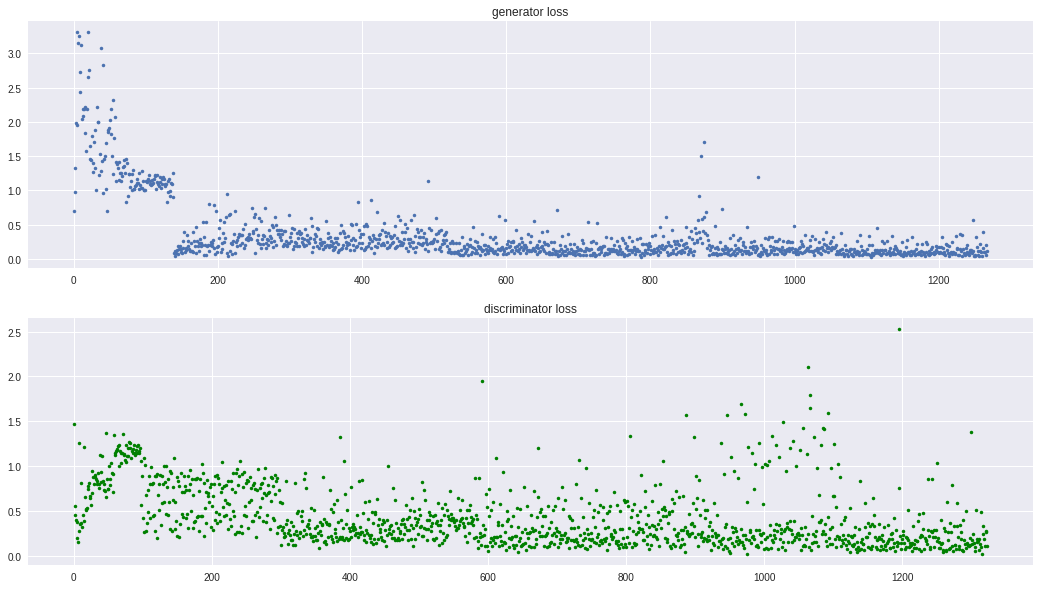

loop: 90


KeyboardInterrupt: 

In [32]:
c = 0
for i in range(loop):
    for X_batch, y_batch in get_batches(X,y,M,kd):
        z = sample_noise(M)
        histd.append( D_train(X_batch, z))
    for X_batch, y_batch in get_batches(X,y,M,kg):
        z = sample_noise(M)
        histg.append(G_train(z))
        
    if visualize_training and c > 14:
        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2,1)
        fig.set_figwidth(18)
        fig.set_figheight(10)
        ax1.plot(histg[::30],'.')
        ax1.set_title('generator loss')
        ax2.plot(histd[::30],'g.')
        ax2.set_title('discriminator loss')
        
        plt.show()
        c = 0
        print('loop:',i)
    c = c + 1
    

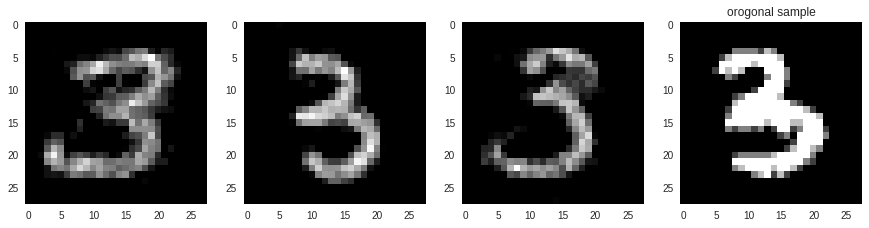

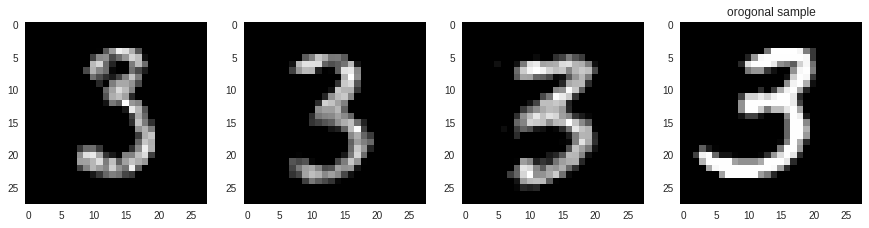

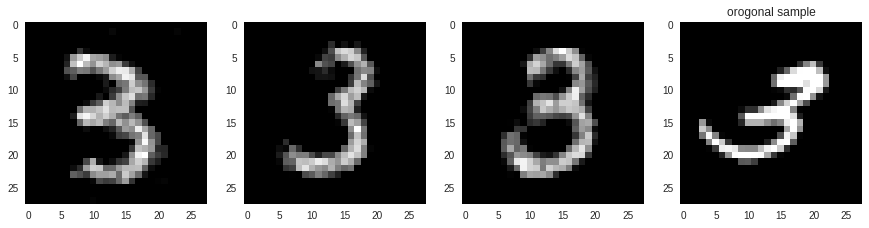

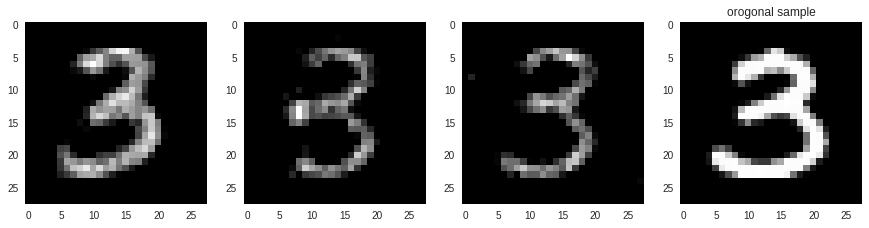

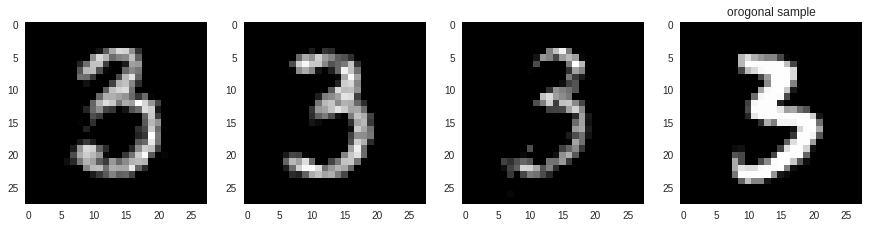

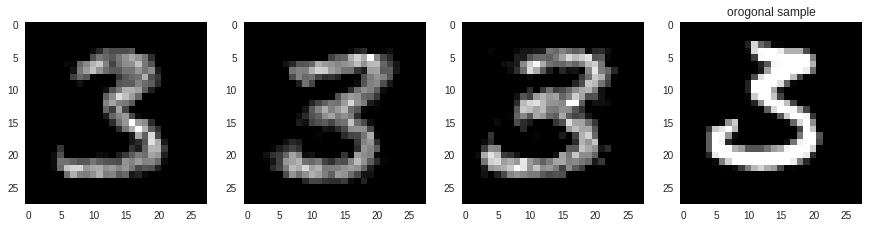

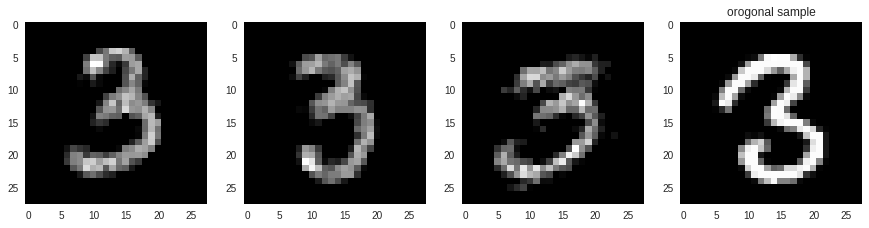

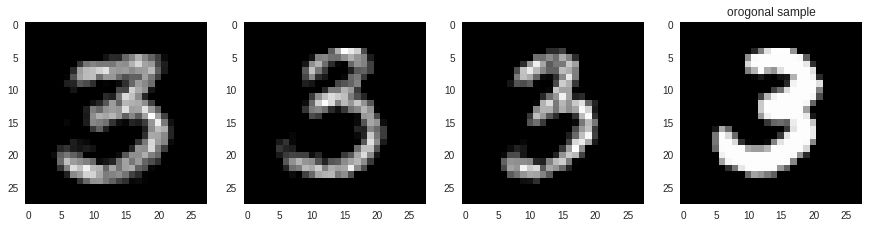

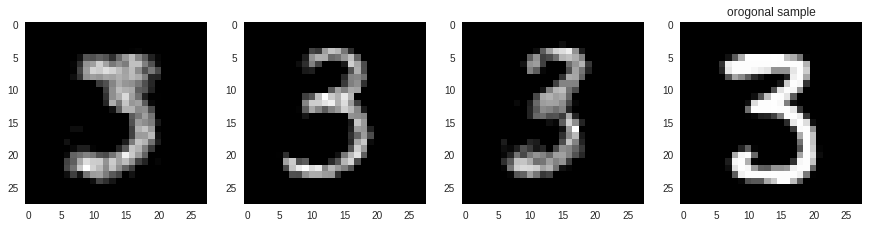

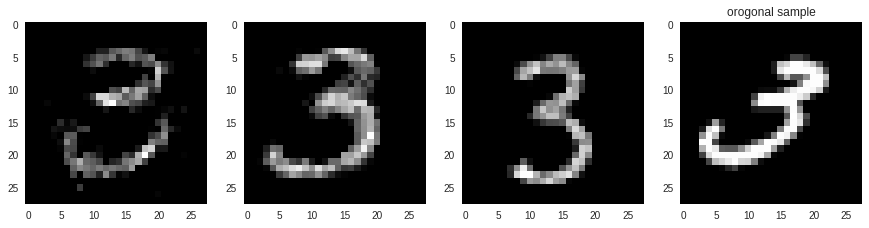

In [33]:
for _ in range(10):
    a = np.random.randint(0,X.shape[0]) 
#     display.clear_output(wait=True)
    f, (ax1,ax2, ax3, ax4) = plt.subplots(1,4)
    f.set_figwidth(15)
    for ax in (ax1,ax2,ax3):
        ax.grid(False)
        im = ax.imshow(generate(sample_noise(1))[0].reshape(28,28), cmap='gray')
#     f.colorbar(im)
    ax4.imshow(X[a].reshape(28,28), cmap='gray')
    ax4.set_title('orogonal sample')
    ax4.grid(False)
    plt.show()
#     print(y[a].argmax())
    time.sleep(0.1)

In [ ]:
for e in range(100):
    for X_batch, y_batch in get_batches(X,y,M):
        z = sample_noise(M)
        histg.append(G_train(z))
    display.clear_output(wait=True)
    print(e)

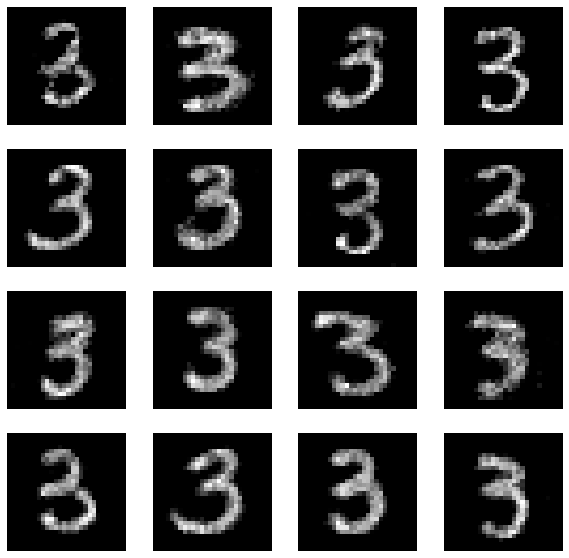

In [39]:
f, axs = plt.subplots(4,4)
f.set_figwidth(10)
f.set_figheight(10)
for ax in axs.flatten():
    ax.grid(False)
    im = ax.imshow(generate(sample_noise(1))[0].reshape(28,28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('genereted threes')

In [ ]:
lasagne.layers.set_all_param_values(D,D_params)
lasagne.layers.set_all_param_values(G,G_params)